# <span style="color:cyan">TP4 - COMPRESSION DU SIGNAL AUDIO </span>

## <span style="color:cyan"><u>PRÉPARATION</u></span>

#### Soit $x[n]$ un signal audio (réel) discret échantillonné à la fréquence d’échantillonnage $F_s$. Afin de le compresser, $x$ est segmenté en trames fenêtrées de $N_{win}$ échantillons. Le pas d’avancement temporel des fenêtres est noté $N_{hop}$. Le débit de compression est noté $D$ (en bits/s).
#### <u>1. Soit $N_{tr}$ le nombre (fractionnaire) de trames dans 1s du signal $x$. Donner le nombre de bits maximal $N_{b_{max}}$ pouvant être alloué à chaque trame en fonction de $D$ et $N_{tr}$.

In [40]:
# Sur une seconde on a Nbitsmax = Debit / Ntr

#### Afin d’évaluer $N_{b_{max}}$, on se propose de déterminer le nombre de trames par seconde $N_{tr}$. Pour cela, on considère une portion $x_1$ de signal $x$ de durée 1s.
#### <u>2. Montrer que le nombre de trames complètes dans $x_1$ est égal à
#### $L = floor[\frac{F_s−N_{win}}{N_{hop}}  + 1]$

In [41]:
#

#### <u>3. Combien de trames incomplètes commencent avant le début de $x_1$ et se terminent dans $x_1$ ? En déduire que le nombre fractionnaire de trames correspondant est égal à :
#### $K_1− \frac{N_{hop}K_1(K_1 + 1)}{2N_{win}}$ avec $K_1 = floor[\frac{N_{win} − 1}{N_{hop}}]$


In [42]:
#

#### <u>4. Combien de trames incomplètes commencent dans $x_1$ et se terminent après la fin de $x_1$ ? En déduire que le nombre fractionnaire de trames correspondant est égal à :

#### $\frac{K_2(F_s − (L − 1)N_{hop})}{N_{win}}− \frac{N_{hop}K_2(K_2 + 1)}{2N_{win}}$ avec $K_2 = floor[\frac{F_{s} − 1}{N_{hop}}]-L+1$

In [43]:
#

#### <u>5. En déduire le nombre total (fractionnaire) $N_{tr}$ de trames dans 1 s de signal $x$.

In [44]:
#

## <span style="color:cyan"><u>EN SÉANCE : 
## <span style="color:cyan">Compression (TP4 = 2h), décodage et décompression (TP5 = 2h)</u></span>

#### La compression de données est un domaine clé dans l’ère du numérique : pouvoir stocker, partager, et lire des données avec le minimum d’espace de stockage, le minimum de mémoire vive, et dans un minimum de temps. La compression audio avec perte (MPEG-1 layer I-II-III) repose sur une idée simple : on ne code pas ce qui ne s’entend pas. Ainsi, l’audio compressé est sensé être identique perceptivement à l’audio original. L’objectif de cette partie est d’étudier un algorithme de compression audio inspiré de la norme MPEG-1 layer III, avec un focus sur l’effet de l’allocation de bits sur la qualité de l’enregistrement audio. Nous allons nous restreindre dans ce TP à étudier l’effet de l’allocation de bits en fréquence sur la qualité perceptive du codage réalisé à partir d’une simple analyse temps-fréquence par TFCT. (Vous pourrez utiliser pour cela la fonction TFCT disponible dans le fichier FourierCT.py du matériel de TP4&5)

In [45]:
# NE PAS MODIFIER CETTE CELLULE
%matplotlib ipympl
import numpy as np
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import sounddevice as sd
import soundfile as sf
from FourierCT import TFCT
from QuantCod import Fuquant

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### <u>Compression et codage audio perceptif</u>
<!-- #### <img src="compression.png" height="250" style="display:block; margin-left:auto; margin-right:auto;">

##### <div align="center"> <em>Schéma d’encodage de la norme MPEG-1. </em></div> -->

##### <u> 1. Calculer la TFCT $X$ du signal audio x.wav de votre choix, avec une taille de fenêtre et un pas d’avancement judicieusement choisis en fonction de la fréquence d’échantillonage du signal audio, et tracer le spectrogramme correspondant en fonction du temps en secondes et des fréquences en Hertz.

/tmp/ipykernel_4376/2478982224.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x_vect = wav.read(PATH)


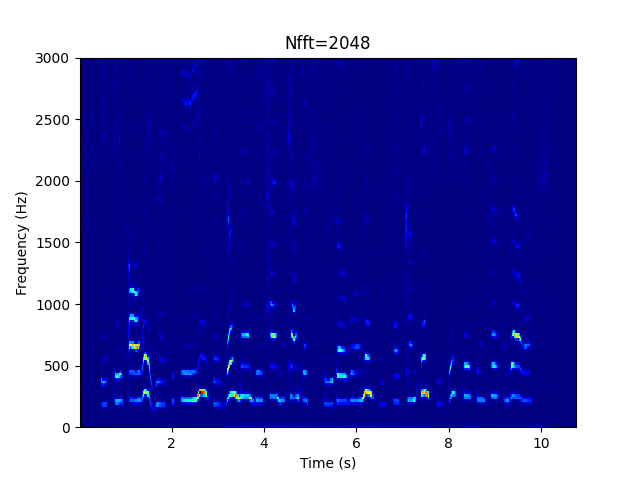

In [46]:
PATH = "Sons/suzanneVega_tomsDiner.wav"

fs, x_vect = wav.read(PATH)

Nwin = 2048
Nfft = 2048
Nhop = 1024
x_mat,t_vect,freq_vect = TFCT(Nwin, Nhop, Nfft, x_vect, fs)

plt.figure()
plt.pcolormesh(t_vect, freq_vect, np.abs(x_mat), cmap='jet')
plt.title(f'Nfft={Nfft}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim((0, 3000))
plt.show()

##### 2. Pour chaque trame temporelle $n$, calculer le facteur de gain $A_n$ permettant la normalisation unitaire du spectre d’amplitude, et calculer ce spectre d'amplitude normalisé, noté xmat_abs_norm.

In [47]:
x_mat_abs_norm = np.zeros(x_mat.shape)
A = np.zeros(x_mat.shape[0])

for n in range(x_mat.shape[1]):
    abs_mat = np.abs(x_mat[:, n])
    if max(abs_mat) != 0:
        A[n] = 1 / max(abs_mat)
        x_mat_abs_norm[:, n] = A[n] * abs_mat

##### <u>3. En utilisant le travail préparatoire, calculer, à partir d’un débit souhaité de 392 kbits/s, le nombre de bits alloué à chaque trame du module noté $|X_{norm}|$ de la TFCT, en fonction des paramètres d’analyse utilisés et de la fréquence d’échantillonnage. En déduire le nombre de bits alloués en moyenne à chaque point fréquentiel.

In [48]:
D = 392000
L = int((fs-Nwin)/Nhop + 1)
K1 = int((Nwin-1)/Nhop)
K2 = int((fs-1)/Nhop)-L+1
N_avant = K1 - (Nhop*K1*(K1+1))/(2*Nwin)
N_apres = (K2*(fs - (L - 1)*Nhop)/Nwin) - (Nhop*K2*(K2 + 1)/(2*Nwin))
Ntr = N_avant + L + N_apres
Nb_max = int(D/Ntr)
print(f"{Nb_max= }")

Nb_max= 9102


##### <u> 4. Calculer la répartition des bits en fréquence pour chaque trame, en utilisant l’algorithme d’allocation de bits perceptif qui minimise la différence entre le rapport signal à masque SMR calculé à partir d’un modèle psycho-acoustique et le rapport SNR calculé en fonction du nombre de bits utilisés pour la quantification.</u> 
##### Pour rappel : NMR(dB) $=$ SMR(dB) − SNR(dB)
##### Pour simplifier, le SMR sera calculé avec un niveau de masque égal à -96 dB (16 bits maximum pour chaque point fréquentiel), et on utilisera l’hypothèse que l’allocation d’1 bit entraîne une augmentation du SNR de 6 dB (et donc une diminution du NMR de 6 dB). On en déduira une matrice d’allocation $Q$.

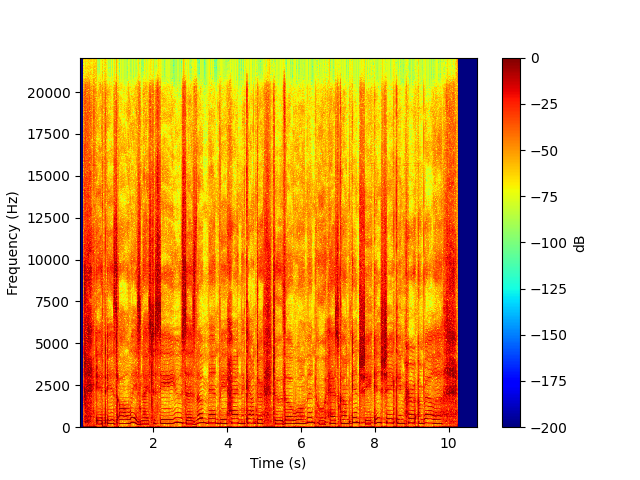

In [49]:
x_mat_dB = np.zeros(x_mat_abs_norm.shape)
Q = np.zeros(x_mat_abs_norm.shape, dtype=int)


epsilon = 1e-10
x_mat_dB = 20 * np.log10(np.maximum(x_mat_abs_norm, epsilon))

plt.figure()
plt.pcolormesh(t_vect, freq_vect, x_mat_dB, cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='dB')
plt.show()

In [50]:
masq = -96 

for n in range(x_mat.shape[1]):
    bits = Nb_max
    m = np.argmax(x_mat_dB[:, n])
    while x_mat_dB[m, n] > masq and bits > 0:
        x_mat_dB[m, n] -= 6
        Q[m, n] += 1
        bits -= 1
        m = np.argmax(x_mat_dB[:, n])

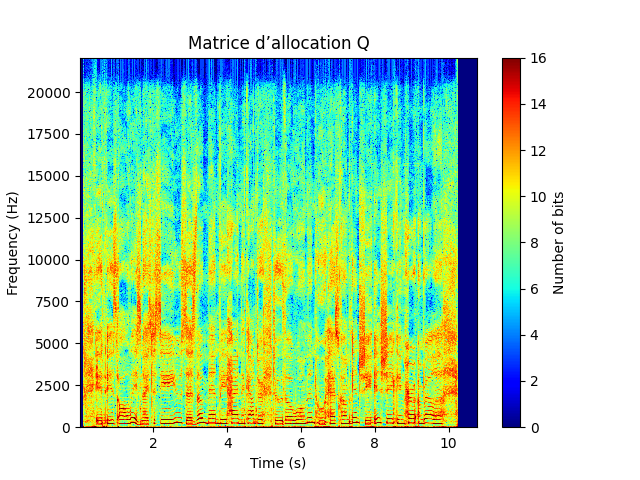

In [51]:
plt.figure()
plt.pcolormesh(t_vect, freq_vect, Q, cmap='jet')
plt.title('Matrice d’allocation Q')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Number of bits')
plt.show()

##### <u>5. Expliciter les conditions d’arrêts à utiliser pour l’arrêt de l’allocation.</u>

In [52]:
# 1. Si l'on n'a plus de bits à allouer
# 2. Si fréquence ayant la plus grande amplitude en dB est inferieure du masque

##### La fonction Fuquant, donnée dans le fichier QuantCod.py du matériel de TP4&5, calcule à partir d’une valeur d’entrée x une valeur y quantifiée et codée. 
##### <u>6. Tracer la caractéristique y = Fuquant(x) de cette fonction et décrire son fonctionnement.</u>

Quantification sur N bits pour des valeurs entre -1 et 1.
Et codage pour les valeurs négative

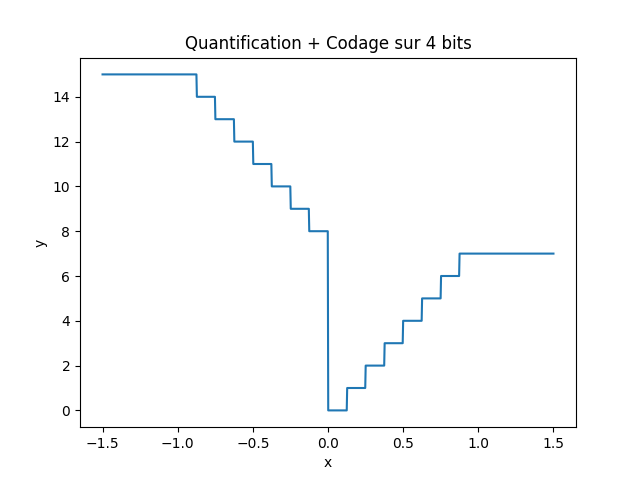

In [53]:
N = 4
x = np.linspace(-1.5, 1.5, 1000)
y = [Fuquant(i, N) for i in x]
plt.figure()
plt.plot(x, y)
plt.title(f'Quantification + Codage sur {N} bits')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

##### <u>7. A l’aide de la fonction Fuquant calculer le spectrogramme $|X_q^{norm}|$ du signal quantifié avec le nombre de bits donné par les éléments de la matrice $Q$, et codé. Tracer le spectrogramme et comparer avec le spectrogramme original en fonction du nombre de bits alloués. Quelles fréquences disparaissent majoritairement ? Expliquer.

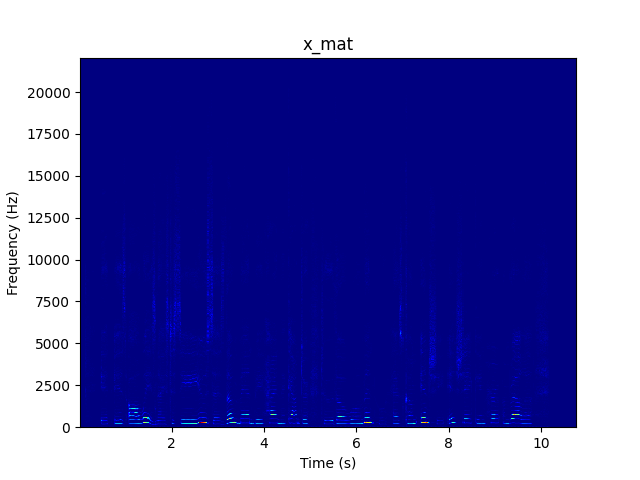

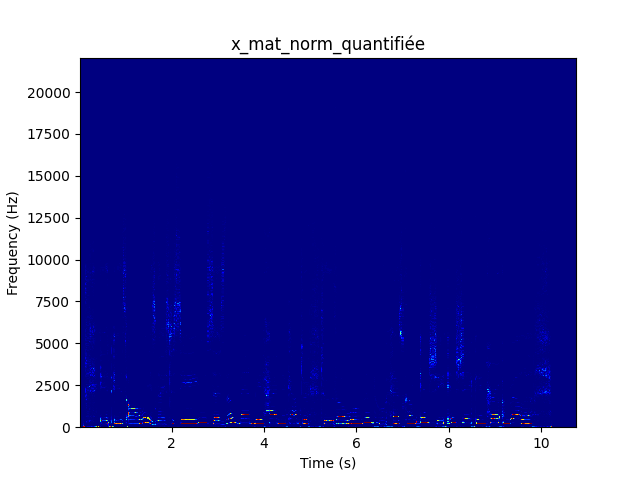

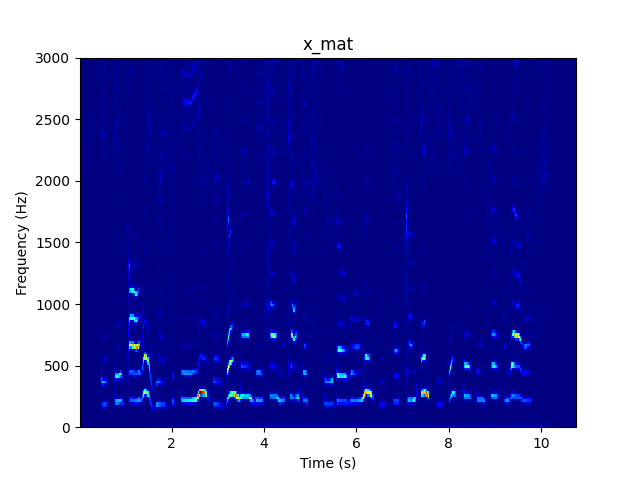

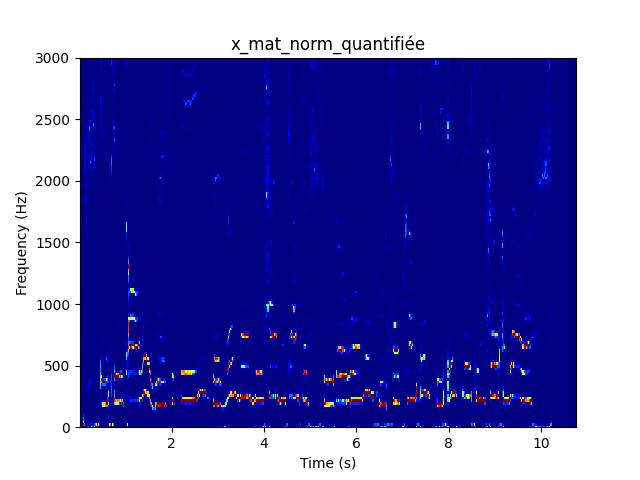

In [54]:
xq = np.zeros(x_mat.shape)

for n in range(x_mat.shape[1]):
    for k in range(x_mat.shape[0]): 
        xq[k,n] = Fuquant(x_mat_abs_norm[k,n], Q[k,n])

plt.figure()
plt.pcolormesh(t_vect, freq_vect, np.abs(x_mat), cmap='jet')
plt.title('x_mat')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.figure()
plt.pcolormesh(t_vect, freq_vect, xq, cmap='jet')
plt.title('x_mat_norm_quantifiée')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.figure()
plt.pcolormesh(t_vect, freq_vect, np.abs(x_mat), cmap='jet')
plt.title('x_mat')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim((0, 3000))
plt.show()

plt.figure()
plt.pcolormesh(t_vect, freq_vect, xq, cmap='jet')
plt.title('x_mat_norm_quantifiée')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim((0, 3000))
plt.show()

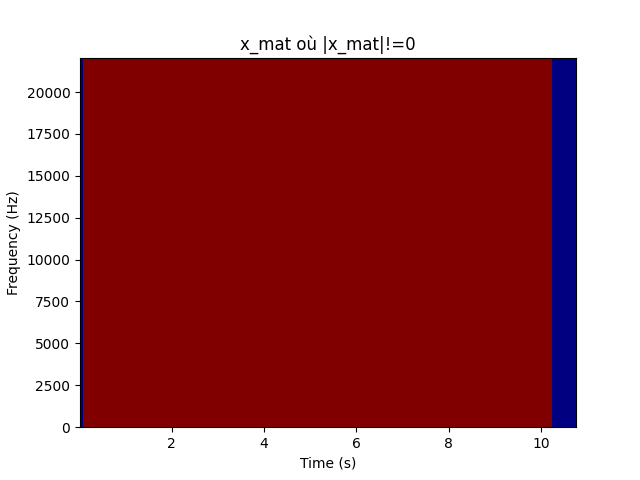

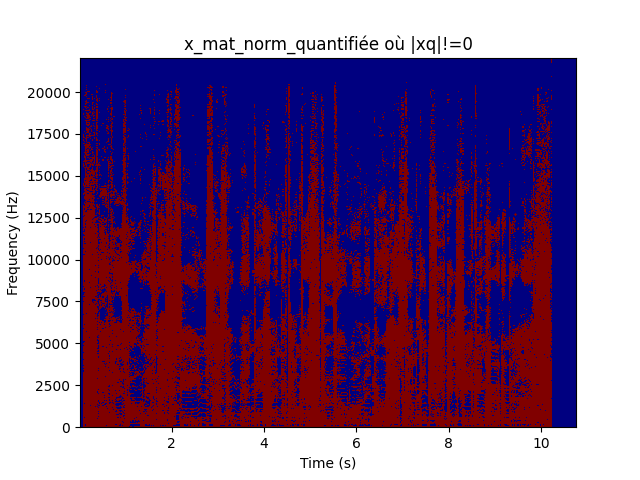

In [55]:
plt.figure()
plt.pcolormesh(t_vect, freq_vect, np.abs(x_mat) != 0, cmap='jet')
plt.title('x_mat où |x_mat|!=0')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.figure()
plt.pcolormesh(t_vect, freq_vect, xq!=0, cmap='jet')
plt.title('x_mat_norm_quantifiée où |xq|!=0')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

Les fréquences qui disparaissent majoritairement sont les hautes fréquences car elles sont moins présentes dans le signal.